In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
error_func = 'conventional' # conventional, SWD

BATCH_SIZE = 256

#define distribution to learn
E_value = 0
sigma = 1
#Data = np.random.normal(E_value, sigma, (100*BATCH_SIZE, 1))
#Data = np.random.uniform(low=0.0, high=10.0, size=(100*BATCH_SIZE, 1))
Data = np.random.binomial(30, 0.2, size=(100*BATCH_SIZE, 1))

tensor_x = torch.Tensor(Data)

train_dataset = torch.utils.data.TensorDataset(tensor_x)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dim = 1

In [23]:

#define generator network
class Generator(nn.Module):
  def __init__(self, gen_input_dim, gen_output_dim):  #gen_input_dim -> dimension of the noise
                                                      #gen_output_dim -> dimension of the output
    super(Generator, self).__init__()

    #define the layers -> mostly fully connected for now
    self.fc1 = nn.Linear(gen_input_dim, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 1024)
    self.fc4 = nn.Linear(1024, gen_output_dim)

  def forward(self, output):
    output = F.leaky_relu(self.fc1(output), 0.01)
    #output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc2(output), 0.01)
    #output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc3(output), 0.01)
    #output = F.dropout(output, p=0.3)
    return self.fc4(output)

#define discriminator network
class Discriminator(nn.Module):
  def __init__(self, disc_input_dim):  #disc_input_dim -> dimension of a sample (28*28)
                                       #output dimension -> probability of a sample being real
    super(Discriminator, self).__init__()

    #define layers -> same as the Generator
    self.fc1 = nn.Linear(disc_input_dim, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1) #the output is a single neuron
  
  def forward(self, output):
    output = F.leaky_relu(self.fc1(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc2(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc3(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc4(output), 0.2)
    return torch.sigmoid(output)



In [24]:
# source: https://github.com/VinAIResearch/DSW
def sliced_wasserstein_dist(real_shape, fake_shape, device, num_projections=1000, p=2):
  dim = fake_shape.size(1)
  projections = torch.randn((num_projections, dim)).to(device)
  projections = projections / torch.sqrt(torch.sum(projections ** 2, dim=1, keepdim=True))
  #projections = projections
  first_projections = real_shape.matmul(projections.transpose(0, 1))
  second_projections = fake_shape.matmul(projections.transpose(0, 1))
  wasserstein_distance = torch.abs(
        (
            torch.sort(first_projections.transpose(0, 1), dim=1)[0]
            - torch.sort(second_projections.transpose(0, 1), dim=1)[0]
        )
    )
  wasserstein_distance = torch.pow(torch.sum(torch.pow(wasserstein_distance, p), dim=1), 1.0 / p)
  return torch.pow(torch.pow(wasserstein_distance, p).mean(), 1.0 / p)

def train_SWD(discriminator, generator, optimizer, minibatch, device, p=2):
  x_real = minibatch.view(-1, train_dim)  #move samples to the right dimension
  y_real = torch.ones(BATCH_SIZE, 1)  #create a label tensor for the real training samples (1 -> real samples)
  criterion = nn.BCELoss()
  x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device)) #move variables to GPU
  noise = Variable(torch.randn(BATCH_SIZE, noise_dim).to(device)) #create random noise for Generator
  x_fake = generator(noise)

  D_out_real = discriminator(x_real.detach())
  D_real_loss = criterion(D_out_real, y_real)
  optimizer.zero_grad()
  D_real_loss.backward()
  optimizer.step()

    

  #train Discriminator on fake samples
  y_fake = torch.zeros(BATCH_SIZE, 1)
  x_fake, y_fake = Variable(x_fake.to(device)), Variable(y_fake.to(device))

  D_out_fake = discriminator(x_fake.detach())
  D_fake_loss = criterion(D_out_fake, y_fake)

  optimizer.zero_grad()
  D_fake_loss.backward()
  optimizer.step()

  data = discriminator(x_real)
  data_fake = discriminator(x_fake)

  _swd = sliced_wasserstein_dist(data, data_fake, device)

  return _swd

def D_train_conventional(x): #x -> batch size of input image data
  D.zero_grad()

  #train Discriminator on real samples
  x_real = x.view(-1, train_dim)  #move samples to the right dimension
  y_real = torch.ones(BATCH_SIZE, 1)  #create a label tensor for the real training samples (1 -> real samples)
  x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device)) #move variables to GPU

  D_out_real = D(x_real)
  D_real_loss = criterion(D_out_real, y_real)

  #train Discriminator on fake samples
  noise = Variable(torch.rand(BATCH_SIZE, noise_dim).to(device)) #create random noise for Generator randn
  x_fake = G(noise)
  y_fake = torch.zeros(BATCH_SIZE, 1)
  x_fake, y_fake = Variable(x_fake.to(device)), Variable(y_fake.to(device))

  D_out_fake = D(x_fake)
  D_fake_loss = criterion(D_out_fake, y_fake)

  #calculate overall loss + backprop
  D_loss = D_real_loss + D_fake_loss
  D_loss.backward()
  D_optim.step()

  return D_loss.data.item()

def G_train_conventional(x):
  G.zero_grad()
  noise = Variable(torch.rand(BATCH_SIZE, noise_dim).to(device)) #randn
  y = torch.ones(BATCH_SIZE, 1)
  y = Variable(y.to(device))

  x = G(noise)
  D_out = D(x)

  G_loss = criterion(D_out, y)
  G_loss.backward()
  G_optim.step()

  return G_loss.data.item()

In [31]:
noise_dim = 10 #dimension of the noise
G = Generator(gen_input_dim=noise_dim, gen_output_dim=train_dim).to(device)
D = Discriminator(disc_input_dim=train_dim).to(device)

#loss function -> BCE loss
if error_func == 'conventional':
  criterion = nn.BCELoss()

#optimizer
lr = 0.0005  #learning rate
G_optim = optim.Adam(G.parameters(), lr=lr)
D_optim = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


numOfEpochs = 20  #number of epochs

In [32]:
start_time = time.time()
for epoch in range(1, numOfEpochs + 1):
  t_loss, D_losses, G_losses = [], [], []
  total_loss = 0.0
  for batch_idx, x in enumerate(train_loader):
    x = x[0]
    #print(x.shape)
    if error_func == 'conventional':
      D_losses.append(D_train_conventional(x))
      G_losses.append(G_train_conventional(x))
    elif error_func == 'SWD':
      loss = train_SWD(D, G, D_optim, x, device)
      D_optim.zero_grad()
      total_loss += loss.item()
      t_loss.append(loss.data.item())
      loss.backward()
      D_optim.step()
    else:
      print(f'There is no error function named {error_func}. Possible values: conventional, SWD, MSWD')
      break

  if error_func == 'conventional':
    print(f'[{epoch}/{numOfEpochs}] Generator loss: {torch.mean(torch.FloatTensor(D_losses))}, Discriminator loss: {torch.mean(torch.FloatTensor(G_losses))}')
  else:
    #print(f'[{epoch}/{numOfEpochs}] Loss: {torch.mean(torch.FloatTensor(total_loss))}')
    print(f"[{epoch}/{numOfEpochs}] Loss: {total_loss}")

training_time = time.time() - start_time
print(training_time)

[1/20] Generator loss: 1.373451590538025, Discriminator loss: 0.8342002630233765
[2/20] Generator loss: 1.3808501958847046, Discriminator loss: 0.7524018883705139
[3/20] Generator loss: 1.3834991455078125, Discriminator loss: 0.7579087018966675
[4/20] Generator loss: 1.3819786310195923, Discriminator loss: 0.7447700500488281
[5/20] Generator loss: 1.3864538669586182, Discriminator loss: 0.7585529088973999
[6/20] Generator loss: 1.3863104581832886, Discriminator loss: 0.7510522603988647
[7/20] Generator loss: 1.3778185844421387, Discriminator loss: 0.7550411820411682
[8/20] Generator loss: 1.3719024658203125, Discriminator loss: 0.7718691825866699
[9/20] Generator loss: 1.3875317573547363, Discriminator loss: 0.7529582381248474
[10/20] Generator loss: 1.385288953781128, Discriminator loss: 0.734230101108551
[11/20] Generator loss: 1.377357840538025, Discriminator loss: 0.7616264224052429
[12/20] Generator loss: 1.373003363609314, Discriminator loss: 0.7523329854011536
[13/20] Generator 

(7680, 1)


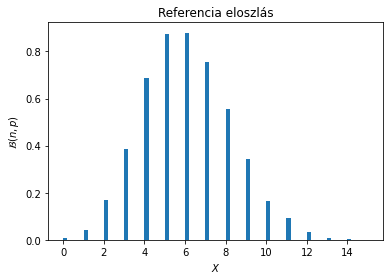

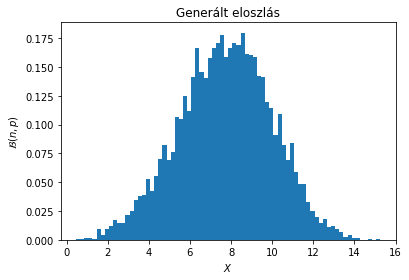

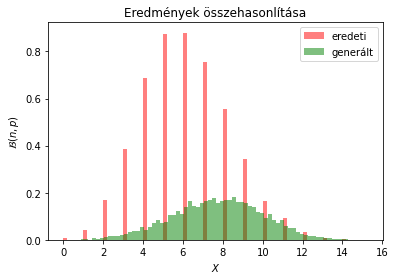

In [61]:
with torch.no_grad():
    test_z = Variable(torch.rand(30*BATCH_SIZE, noise_dim).to(device))
    generated = G(test_z)
    generated = generated.cpu().detach().numpy()
    binom = list(filter(lambda x: type(x)==int, generated))
    binom = np.array(binom)
    print(generated.shape)
    #np.seterr(divide='ignore', invalid='ignore')

f, ax = plt.subplots(1)
#Data = np.random.normal(E_value, sigma, (30*BATCH_SIZE, 1))
#Data = np.random.uniform(low=0.0, high=10.0, size=(30*BATCH_SIZE, 1))
Data = np.random.binomial(30, 0.2, size=(30*BATCH_SIZE, 1))

binwidth = 0.2
bino = np.arange(min(Data), max(Data) + binwidth, binwidth)
bing = np.arange(min(generated), max(generated) + binwidth, binwidth)

plt.hist(Data, bino, density=True)
#plt.xlim(0, 30)
plt.xlabel('$X$')
plt.ylabel('$\mathcal{B}(n, p)$')
plt.title('Referencia eloszlás')
plt.show()

plt.hist(generated, bing, density=True)
#plt.xlim(-10, 10)
plt.xlabel('$X$')
plt.ylabel('$\mathcal{B}(n, p)$')
plt.title('Generált eloszlás')
plt.show()

plt.hist(Data, bino, alpha=0.5, label='eredeti', color='r', density=True)
plt.hist(generated, bing, alpha=0.5, label='generált', color='g', density=True)
plt.legend(loc='upper right')
#plt.xlim(-10, 10)
plt.xlabel('$X$')
plt.ylabel('$\mathcal{B}(n, p)$')
plt.title('Eredmények összehasonlítása')
plt.show()

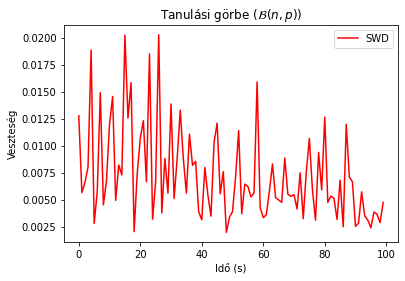

In [20]:
plt.title('Tanulási görbe ($\mathcal{B}(n, p)$)')
plt.xlabel('Idő (s)')
plt.ylabel('Veszteség')
if error_func == 'conventional':
  plt.plot(D_losses, 'r', label='Diszkriminátor')
  plt.plot(G_losses, 'b', label='Generátor')
else:
  plt.plot(t_loss, 'r', label='SWD')
plt.legend(loc='upper right')
plt.show()